In [1]:
from datasets.image_data import ImageDataset
from datasets.data import SkinLesionDataset
from datasets.split_data import DataSplitter
from models.transform import get_transforms
from models.unet import UNet
from models.attention_unet import AttUNet
from models.trans_unet import TransUNet
from results.plots import plot_img_mask_pred
from torch.utils.data import DataLoader
import torch

c:\Users\user\Deep Learning\melanoma-segmentation-and-classification\venv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Test the ImageDataset class
base_dir = "data"
image_folder = "ISIC-2017_Training_Data"
gt_folder = "ISIC-2017_Training_Part1_GroundTruth"
model = "unet"
split_train = 0.8
split_val = 0.1
split_test = 0.1
image_size = 128
batch_size = 16

In [3]:
# Recieve the image and ground truth paths
dataset_paths = ImageDataset(base_dir, image_folder, gt_folder)
print("Retrieving image and ground truth paths...")
print(dataset_paths)
# Split the data into training, validation, and testing sets (Paths)
image_paths, gt_paths = dataset_paths.get_image_and_gt_paths()

split = DataSplitter(
    image_paths,
    gt_paths,
    split_train,
    split_val,
    split_test,
)
img_train_p, img_val_p, img_test_p, gt_train_p, gt_val_p, gt_test_p = split.split_data()

# Get the train test and validation datasets based on the paths
train_dataset = SkinLesionDataset(
    img_train_p, gt_train_p, transform=get_transforms("train", image_size)
)
val_dataset = SkinLesionDataset(
    img_val_p, gt_val_p, transform=get_transforms("test", image_size)
)
test_dataset = SkinLesionDataset(
    img_test_p, gt_test_p, transform=get_transforms("test", image_size)
)

# Get the train test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Retrieving image and ground truth paths...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555356..0.75764704].


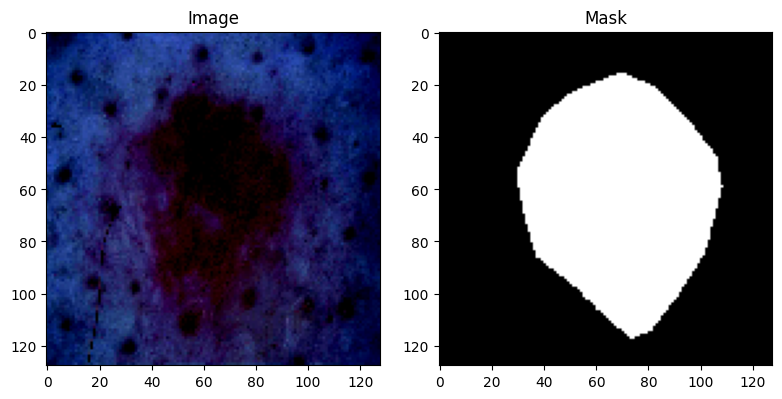

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151553..2.5179956].


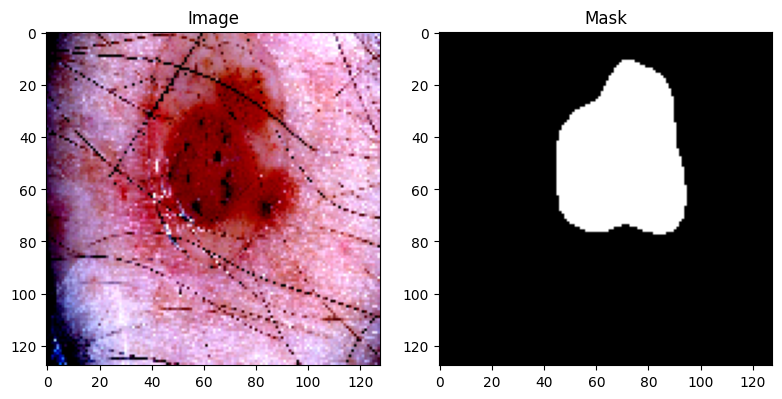

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8439078..1.4782943].


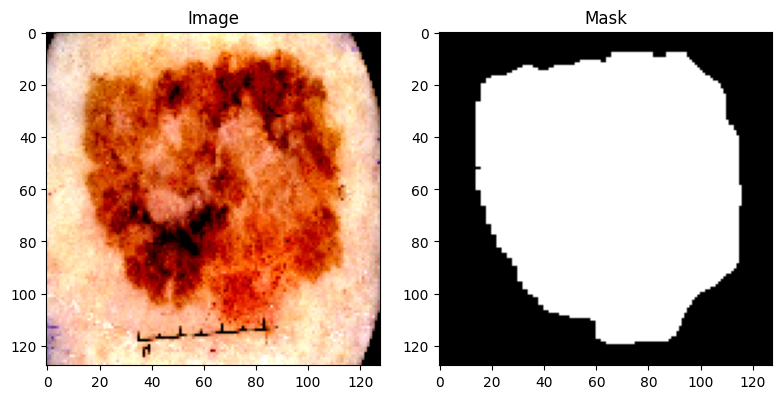

In [4]:
plot_img_mask_pred(train_dataset)
plot_img_mask_pred(val_dataset)
plot_img_mask_pred(test_dataset)


# Train Model